# Mimicking the Simulation of Boids using Neural Networks

Adaptive Systems Seminar: Project  
Computer Science - **Wouter Apts** - 0606577

In [1]:
# The following libraries are used for this project:
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import cv2 

from os.path import join
from time import strftime, localtime
from cv2 import VideoWriter, VideoWriter_fourcc as FourCC
from sklearn.neural_network import MLPRegressor

### 1. Introduction
In this project, we aim to train a neural network to emulate the behavior of a traditionally coded 'Boids' simulator, which replicates the flocking behavior observed in birds. The concept of 'Boids' was initially introduced by Craig Reynolds in 1987
*[1]*.

To achieve this goal, we will begin by developing a rule-based Boids simulator to generate ground-truth data. 
A Boids simulation consists out of multiple autonomous agents (boids), that all follow a simple set of rules to determine their behaviour. The 3 main rules applied in the simplest simulations are as follows:

- **coherence:** each boid moves towards the average position of its neighbours.
- **alignment:** each boid tries to match the velocity vector (speed and direction) of its neighbours
- **separation:** each boid steers away from nearby obstacles to avoid colliding into neighbours and borders.

Each boid's knowledge is limited to its immediate surroundings, determined by their 'detection radius'.
Additionally, each boid has a smaller 'avoidance radius', which will cause boids to move away from obstacles within this predetermined range.

Furthermore, Boids have a minimum and maximum movement speed, as well as a turning factor. The simulation parameters can be altered below.

### 2. Simulation Implementation
#### 2.1 Simulation Code

In [2]:
# SIMULATION PARAMETERS
DETECTION_RADIUS = 100.0
AVOIDANCE_RADIUS = 20.0

COHERENCE_FACTOR = 0.01
ALIGNMENT_FACTOR = 0.05
SEPARATION_FACTOR = 0.5
TURN_FACTOR = 10.0

BOID_MIN_SPEED = 100
BOID_MAX_SPEED = 150
BOID_NOSE_LEN = 10
BOID_COLOR = (0xc8, 0xc8, 0xe8)

RESOLUTION = [1080,720]
FPS = 30

OUT_DIR = "./out/"
SCALE = 1.0 
BACKGROUND_COLOR = (0x2A, 0x18, 0x0B)

In [3]:
# Auxiliary methods
def unit_vector(angle):
    return np.array([np.cos(angle), np.sin(angle)], dtype="float")

def angle(vector):
    return np.arctan2(vector[1], vector[0])

def normalize(vector):
    return vector if np.allclose(vector, 0) else vector / np.linalg.norm(vector)

In [4]:
class Boid():
    def __init__(self, position, velocity):
        self.position = np.array(position, dtype="float")
        self.velocity = np.array(velocity, dtype="float")
  
    @property
    def direction(self):
        return normalize(self.velocity)
    
    @property
    def angle(self):
        return angle(self.velocity)
        
    # return distance between the boid and a given position
    def distance(self, position):
        return np.linalg.norm(self.position - position)
    
    def draw(self, canvas):
        tip = self.position + BOID_NOSE_LEN * self.direction
        left = self.position + BOID_NOSE_LEN / 2 * unit_vector(self.angle + np.pi *2/3)
        right = self.position + BOID_NOSE_LEN / 2 * unit_vector(self.angle - np.pi *2/3)
        canvas.draw_poly([tip, left, self.position, right], BOID_COLOR)

    def step(self, t):
        self.position += self.velocity * t

In [5]:
class Simulation():
    def __init__(self, canvas):
        self.boids = []
        self.canvas = canvas

    def create_boid(self, position, velocity):
        self.boids.append(Boid(position, velocity))
    
    def create_boids(self, amount, seed):
        np.random.seed(seed)
        for _ in range(amount):
            random_position = 0.8 * self.canvas.size * (1 - 2 * np.random.random(2))
            random_velocity = BOID_MAX_SPEED * (1 - 2 * np.random.random(2))
            self.create_boid(random_position, random_velocity)
            
    def get_neighbours(self, boid):
        neighbours = []
        for other in self.boids:
            if (np.linalg.norm(boid.position - other.position) < DETECTION_RADIUS) and boid is not other:
                neighbours.append(other)
        return neighbours
    
    # Used to update boid velocity using coded rules
    def update_velocity_using_rules(self, boid):
        
        neighbours = self.get_neighbours(boid)
        neighbours_length = len(neighbours)
        
        avg_position = np.array([0, 0], dtype='float')  
        avg_velocity = np.array([0, 0], dtype='float')  
        avoid_boids = np.array([0, 0], dtype='float')  

        if len(neighbours) != 0:
            for i, other in enumerate(neighbours):
                difference = other.position - boid.position

                avg_position += (other.position - avg_position) / (i + 1)  # Cumulative average formula
                avg_velocity += (other.velocity - avg_velocity) / (i + 1)  # Cumulative average formula
                
                if boid.distance(other.position) < AVOIDANCE_RADIUS:
                    avoid_boids += boid.position - other.position
     
            boid.velocity += (avg_position - boid.position) * COHERENCE_FACTOR # Coherence rule
            boid.velocity += (avg_velocity - boid.velocity) * ALIGNMENT_FACTOR # Alignment rule
            boid.velocity += (avoid_boids) * SEPARATION_FACTOR                 # Separation rule
        
        # Avoid collision with borders
        if boid.position[0] > (self.canvas.size[0] - DETECTION_RADIUS):
            boid.velocity[0] -= TURN_FACTOR
        if boid.position[0] < (DETECTION_RADIUS - self.canvas.size[0]):
            boid.velocity[0] += TURN_FACTOR    
        if boid.position[1] > (self.canvas.size[1] - DETECTION_RADIUS):
            boid.velocity[1] -= TURN_FACTOR
        if boid.position[1] < (DETECTION_RADIUS - self.canvas.size[1]):
            boid.velocity[1] += TURN_FACTOR    
            
        # Limit the speed 
        if (speed := np.linalg.norm(boid.velocity)) > BOID_MAX_SPEED:
            boid.velocity = (boid.velocity / speed) * BOID_MAX_SPEED
        if (speed := np.linalg.norm(boid.velocity)) < BOID_MIN_SPEED:
            boid.velocity = (boid.velocity / speed) * BOID_MIN_SPEED    
    
    # Used to update boid velocity based on neural network output
    def update_velocity_using_nn(self, boid, model):
        input_data = self.get_input_data(boid, model['k_neighbours'])
        boid.velocity = model['model'].predict([input_data])[0]
         
    def draw(self):
        self.canvas.fill(BACKGROUND_COLOR)
        for boid in self.boids:
            boid.draw(self.canvas)
        self.canvas.update()

    def step(self, model = None):
        # update velocitiy of each boid
        if model:
            for boid in self.boids:
                self.update_velocity_using_nn(boid, model)
        else:
            for boid in self.boids:
                self.update_velocity_using_rules(boid)
        # update position of boids
        for boid in self.boids:
            boid.step(1/FPS)
    
    def run(self, dataset_size = 0, k_neighbours = 0, model = None, metric_steps = None):
            X_set, y_set = [], []
            avd_set, amd_set, mmd_set = [], [], []
            data = None
            while self.canvas.is_open(): 
                if metric_steps:
                    avd, amd, mmd = self.get_metrics()
                    avd_set.append(avd)
                    amd_set.append(amd)
                    mmd_set.append(mmd)
                    if (len(avd_set) >= metric_steps):
                        return avd_set, amd_set, mmd_set
                if dataset_size:
                    data = self.get_input_data(self.boids[0], k_neighbours)
                    if (len(X_set) < dataset_size):
                        X_set.append(data)
                        y_set.append(data[2:4])
                        self.draw()
                        self.step(model)
                    else:
                        y_set.append(data[2:4])
                        y_set = y_set[1:]
                        return X_set, y_set
                self.draw()
                self.step(model)
                
    # Get input data for boid              
    def get_input_data(self, boid, k):
        data = [boid.position, boid.velocity]
        def distance(otherBoid):
            return np.linalg.norm(boid.position - otherBoid.position)
        k_closest_neighbours = sorted([x for x in self.boids if x != boid], key=distance)[:k]
        for neighbour in k_closest_neighbours:
            data.append(neighbour.position)
            data.append(neighbour.velocity)   
        data = np.concatenate(data)
        data = np.append(data, -self.canvas.size - boid.position)
        data = np.append(data, self.canvas.size - boid.position)
        return data
    
    # Evalutation metrics
    def get_metrics(self):
        n = len(self.boids)
        cumulative_vel_diff = 0
        closest_distances = []
        for b1 in self.boids:
            closest_neighbor = None 
            closest_neighbor_dist, min_distance = float('inf'), float('inf') 
            for b2 in self.boids:
                if b1 != b2:
                    dist = np.linalg.norm(b1.position - b2.position)
                    if dist < closest_neighbor_dist:
                        closest_neighbor = b2
                    min_distance = min(min_distance, dist)
            cumulative_vel_diff += np.linalg.norm(b1.velocity - closest_neighbor.velocity)
            closest_distances.append(min_distance)
            
        avd = (1/n) * cumulative_vel_diff # Evaluation metric: Average velocity difference between closest neighbours
        amd = (1/n) * np.sum(closest_distances) # Evaluation metric: average minimum distance to neighbour
        mmd = np.median(closest_distances)  # Evaluation metric: median minimum distance to neighbour
        return avd, amd, mmd

In [6]:
class Canvas():
    def __init__(self, resolution, fps):
        # output related
        self.resolution = np.array(resolution, dtype="int")
        self.fps = float(fps)
        self.current_frame = self.new_frame()
        self.closed = False

        # renderer
        self.filename = OUT_DIR + strftime('%Y%m%dT%H%M%S', localtime()) + ".mp4"
        self.title = f"Boids Simulation - {self.filename}"
        self.video = VideoWriter(self.filename, FourCC(*"h264"), int(self.fps), tuple(self.resolution))
     
    def __enter__(self):
        return self

    def __exit__(self, *args, **kwargs):
        cv2.destroyWindow(self.title)
        self.video.release()

    @property
    def size(self):
        return np.abs(self.from_px(self.resolution))

    def to_px(self, pos):
        return (pos / [1, -1] + self.resolution / 2).astype("int")

    def from_px(self, px):
        return (px.astype("float") - self.resolution / 2) * [1, -1]

    def is_open(self):
        return not self.closed

    def new_frame(self):
        return np.ndarray(shape=(*self.resolution[::-1], 3), dtype="uint8")

    def update(self):
        self.video.write(self.current_frame)
        cv2.imshow(self.title, self.current_frame)
        self.current_frame = self.new_frame()

        self.closed |= (cv2.getWindowProperty(self.title, 0) < 0) or (cv2.waitKey(int(1000 / self.fps)) in {27, 2, 3, ord("q"), ord("Q")})

    def fill(self, color):
        self.current_frame[:, :] = np.array(color, dtype="uint8")

    def draw_poly(self, points, color):
        cv2.fillPoly(self.current_frame,
                     [np.array([self.to_px(p) for p in points])], color,16) 


#### 2.2 Visualization
Ground-truth simulation video:

<video controls src="./simulation_videos/ground_truth_sim.mp4"></video>

Below you can run the ground-truth simulation and create a new video file, it also calculates the evaluation metrics:

In [7]:
# VISUAL DEMO: ground-truth simulation using coded rules
BOIDS_AMOUNT = 50
with Canvas(RESOLUTION, FPS) as canvas:
    sim = Simulation(canvas)
    sim.create_boids(BOIDS_AMOUNT, seed=42)
    avd, amd, mmd = sim.run(metric_steps = 2000)
    
    np.save('./metrics/avd_ground_truth.npy', avd)
    np.save('./metrics/amd_ground_truth.npy', amd)
    np.save('./metrics/mmd_ground_truth.npy', mmd)

### 3. Neural Network Implementation
#### 3.1 Knowledge-based Approach

A sub-optimal way of approaching the problem would be to train a neural network by feeding it datapoints that only contain the position values of all boids at each step, and have the neural network predict the positions on the following step. This model would act as a 'global' controller, calculating the next state for all boids simultaniously.

Instead of taking this global approach, we can use our knowledge of the inner dynamics of the simulation to create a model that will control each boid individually. A boid's full state can be described as: $x = [r, v]$

Where $r$ is its positional vector and $v$ is its velocity vector. Additionaly, the change in a boid's velocity is only dependant on its close neighbours and borders. Using this information, which we can extract from the ground-truth data, we can create more meaningful input data to train the network with.

Note that if you were only given image snapshots at each step, it would still be possible to derive the velocity of a boid using the formula: $\frac{{\text{pos}_{t_{i+1}} - \text{pos}_{t_{i}}}}{{dt}}$


#### 3.2 Creating Dataset

The following training and evaluation method is a modified approach of the method proposed in the 2021 paper '*Learning to Swarm with knowledge-based Neural Ordinary Differential Equations*' *[2]*.

The training data created consists out of 30 boid trajectories, each with a total length of 2000 steps. This step count is chosen such that the boids will have converged to stable flocking by the end of each simulation run. 

Each step generates one datapoint of size $(4 + 4k + 4)$. The first 4 values are the state values (position and velocity) of the tracked boid. The next $4k$ values are the state values of its $k$ nearest neighbours. The final 4 values are the distance of the boid to the right, top, left and bottom border respectively.

In [ ]:
# CREATE training dataset (THIS TAKES APROX. 2 HOURS!)
# running this is NOT necessary, the datasets are saved in de root folder.

X_train, y_train = [], []
TRAJECTORIES = 30
STEPS_PER_TRAJECTORY = 2000
K_NEIGHBOURS = 6

for i in range(TRAJECTORIES):
    with Canvas(RESOLUTION, FPS) as canvas:
        sim = Simulation(canvas)
        sim.create_boids(50, seed=i)
        X, y = sim.run(dataset_size=STEPS_PER_TRAJECTORY, k_neighbours=K_NEIGHBOURS)
        X_train.append(X)
        y_train.append(y)
X_train = np.concatenate(X_train)  
y_train = np.concatenate(y_train) 

print(f'dataset created with size: {len(X_train)}')

# Save the training set to a file
X_file_name = 'boids_training_set_X.npy'
np.save(X_file_name, X_train)
y_file_name = 'boids_training_set_y.npy'
np.save(y_file_name, y_train)

print(f'Dataset X saved to {X_file_name}')
print(f'Dataset y saved to {y_file_name}')

#### 3.2 Training the Neural Network
The neural network has one hidden layer with 128 nodes, using the 'hyperbolic tangent' activation function. Training is performed using 'adam', a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba *[3]*.

The network takes the above mentioned datapoints as input and outputs a prediction for the updated velocity vector.
Two models were trained, one with Gaussian noise added to the training data, and one without. 

In [8]:
K_NEIGHBOURS = 6
def get_trained_neural_network(Gaussian_noise = False):  
    # LOAD existing dataset:
    X_train = np.load('boids_training_set_X.npy')
    y_train = np.load('boids_training_set_y.npy')

    if Gaussian_noise:
        # Adding gaussian noise with variance 0.001 to the trajectories datapoints.
        variance = 0.001
        np.random.seed(0)
        noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=(len(X_train), 4*(2+K_NEIGHBOURS)))
        X_train = X_train + noise

    # TRAINING model using MLPRegressor
    model = MLPRegressor(
        hidden_layer_sizes=(128),
        activation='tanh',
        solver='adam',  
        max_iter=1000,  
        random_state=1)

    model.fit(X_train, y_train)
    
    print('training completed!')
    print(f'epochs: {model.n_iter_}')
    return {'model' : model, 'k_neighbours' : K_NEIGHBOURS}

nn_model_1 = get_trained_neural_network(Gaussian_noise = False)  
nn_model_2 = get_trained_neural_network(Gaussian_noise = True)  

training completed!
epochs: 150
training completed!
epochs: 155


#### 3.3 Visualization
Neural Network simulation (Trained without noise):

<video controls src="./simulation_videos/nn_model_1_sim.mp4"></video>

Neural Network simulation (Trained with Gaussian noise):

<video controls src="./simulation_videos/nn_model_2_sim.mp4"></video>

Below, you can run the Neural Network controlled simulations yourself and create a new video file:

In [9]:
# Neural Network without Gaussian noise added to training data:
with Canvas(RESOLUTION, FPS) as canvas:
    sim = Simulation(canvas)
    sim.create_boids(BOIDS_AMOUNT, seed=42)
    avd, amd, mmd = sim.run(model = nn_model_1, metric_steps = 2000)
    
    np.save('./metrics/avd_nn_model_1.npy', avd)
    np.save('./metrics/amd_nn_model_1.npy', amd)
    np.save('./metrics/mmd_nn_model_1.npy', mmd)

In [10]:
# Neural Network WITH Gaussian noise added to training data:
with Canvas(RESOLUTION, FPS) as canvas:
    sim = Simulation(canvas)
    sim.create_boids(BOIDS_AMOUNT, seed=42)
    avd, amd, mmd = sim.run(model = nn_model_2, metric_steps = 2000)
        
    np.save('./metrics/avd_nn_model_2.npy', avd)
    np.save('./metrics/amd_nn_model_2.npy', amd)
    np.save('./metrics/mmd_nn_model_2.npy', mmd)

### 4. Evaluation

To evaluate, we compare it to the ground truth using the following metric, as proposed by paper *[2]*.
- **Average Minimum Distance to Neighbour** (amd)

Additionally, we add another slightly modified metric:
- **Median Minimum Distance to Neighbour** (mmd)

The (amd) metric measures the coherence between boids; this should decrease as well.

The (mmd) metric also measures the coherence between boids but uses the median; this makes the measurement more robust against heavy outliers. (For example, boids that have strayed off very far)

The code for these metrics can be found in the 'Simulation' Class.

#### 4.1 Plots
Below we plot the (avd), (amd) and (mmd) for the ground-truth simulator and the two NN-controlled simulations:

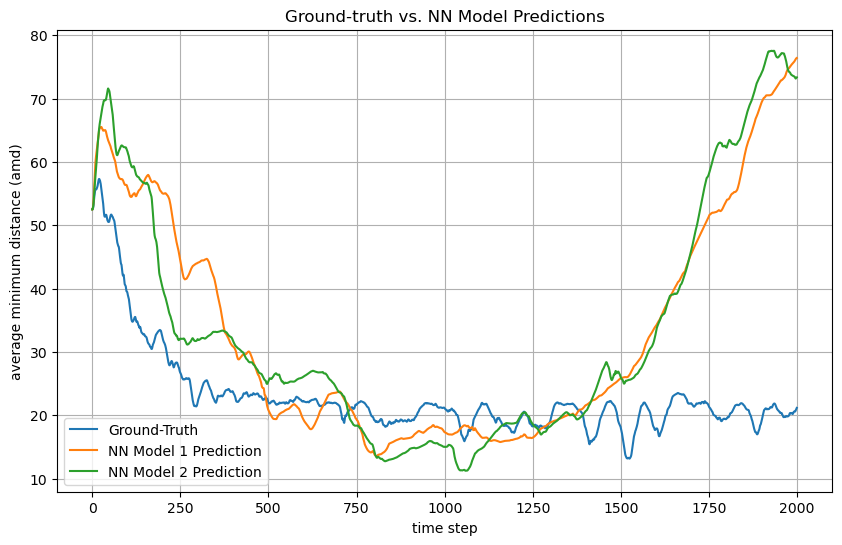

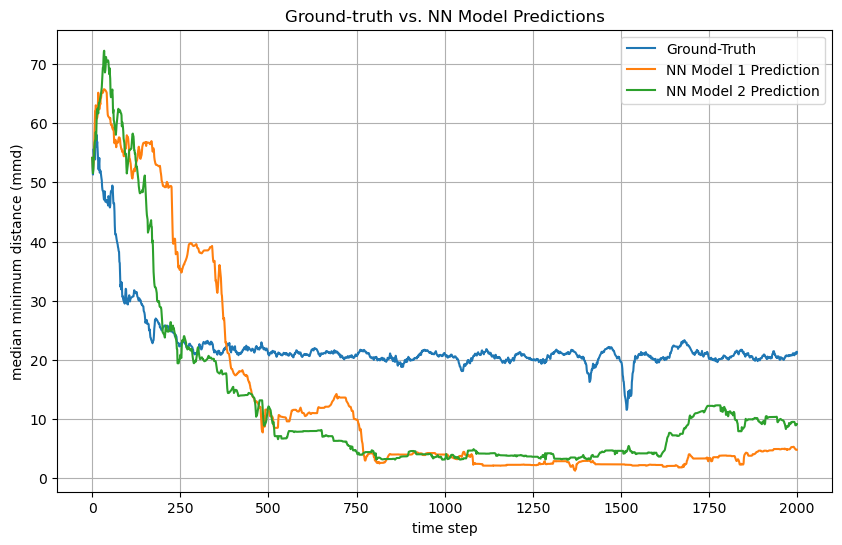

In [11]:
def plot_metric_data(g_truth, model_1_pred, model_2_pred, metric):
    # Create the x-axis values (index of values in the vectors)
    x_axis = np.arange(2000)

    plt.figure(figsize=(10, 6)) 
    plt.plot(x_axis, g_truth, label='Ground-Truth')
    plt.plot(x_axis, model_1_pred, label='NN Model 1 Prediction')
    plt.plot(x_axis, model_2_pred, label='NN Model 2 Prediction')
    plt.xlabel('time step')
    plt.ylabel(metric)
    plt.title('Ground-truth vs. NN Model Predictions')
    plt.legend()
    plt.grid(True)

    plt.show()

ground_truth = np.load('./metrics/amd_ground_truth.npy')  
model_1_prediction = np.load('./metrics/amd_nn_model_1.npy')  
model_2_prediction = np.load('./metrics/amd_nn_model_2.npy')
plot_metric_data(ground_truth, model_1_prediction, model_2_prediction, 'average minimum distance (amd)')

ground_truth = np.load('./metrics/mmd_ground_truth.npy')  
model_1_prediction = np.load('./metrics/mmd_nn_model_1.npy') 
model_2_prediction = np.load('./metrics/mmd_nn_model_2.npy')
plot_metric_data(ground_truth, model_1_prediction, model_2_prediction, 'median minimum distance (mmd)')

#### 4.2 Discussion
As expected, all the metrics for the ground-truth simulator exhibit a consistent decline over time, signaling a gradual convergence towards stable flocking behavior.

What's iinteresting is the trend observed in the average minimum distance (amd) metric for the NN-controlled boids. Initially, it decreases steadily until approximately step 1000, after which it unexpectedly rises to a high value. This shift can primarily be attributed to a small number of boids that, for unknown reasons, wander far beyond the border, causing a significant spike in the average. Clearly, this behavior represents a shortcoming in the neural network-controlled simulation. To account for this, we can turn to the minimum mean distance (mmd) metric.

The (mmd) metric reveals that the majority of the NN-controlled boids do indeed exhibit a convergence towards flocking behavior, albeit not all of them. 

### 5. Conclusion 

The Neural networks are somewhat effective at mimicking the dynamics of the Boids Simulator.

Visually, the NN-controlled boids exhibit flocking behavior somewhat resembling the ground-truth simulator, which is a good sign. Our metrics confirm this to some extent. However, there are a lot of quirks. The movement of NN-Controlled boids is more jagged, change of direction often happens too abruptly, borders aren't respected as thightly and boids are either too close or too far appart when flocking. Another problem, as observed through the 'amd' metric, is that a few boids tend to stray off, far away from others and won't return.

To improve, we can tweak parameters like the number of neighbors, the trajectories, time steps, and boid count during training. These changes might help us get even better flocking behavior, closer to what we see in the original simulator.

### References

**[1]** Reynolds, C. W. (1987) Flocks, Herds, and Schools: A Distributed Behavioral Model, in Computer Graphics, 21(4) (SIGGRAPH '87 Conference Proceedings) pages 25-34. 

**[2]** Jiahao, T.Z., Pan, L. and Hsieh, M.A. (2021) Learning to swarm with knowledge-based neural ordinary differential equations, arXiv.org. Available at: https://arxiv.org/abs/2109.04927. 

**[3]** Kingma, D.P. and Ba, J. (2017) Adam: A method for stochastic optimization, arXiv.org. Available at: https://arxiv.org/abs/1412.6980.